In [1]:
import pandas as pd
import torch
import sklearn
import numpy as np

import transformers

c:\Users\robin\anaconda3\envs\dnabert\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.empty_cache()

In [3]:
modelpath = "zhihan1996/DNABERT-2-117M"
df = pd.read_csv("./sample_data/esp_decoded.csv")

print(df.info())

print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56888 entries, 0 to 56887
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   seq     56888 non-null  object 
 1   y       56888 non-null  float64
dtypes: float64(1), object(1)
memory usage: 889.0+ KB
None
                     seq         y
0  AAAAAAAAACTCCAAAACCCT  0.093147
1  AAAAAACAACAAGAAGCACAA  0.064951
2  AAAAAACACAAGCAAGACCGT  0.061797
3  AAAAAACAGATGCCACCTGTG  0.057246
4  AAAAAACCCGTAGATAGCCTC  0.067596


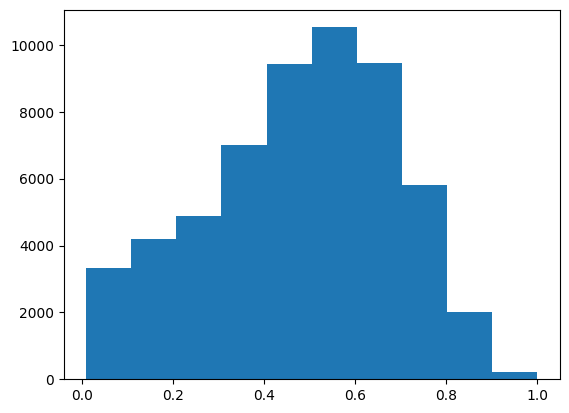

In [4]:
import matplotlib.pyplot as plt

#plot label distribution
plt.hist(df['y'])
plt.show()

                     seq  y
0  AAAAAAAAACTCCAAAACCCT  0
1  AAAAAACAACAAGAAGCACAA  0
2  AAAAAACACAAGCAAGACCGT  0
3  AAAAAACAGATGCCACCTGTG  0
4  AAAAAACCCGTAGATAGCCTC  0


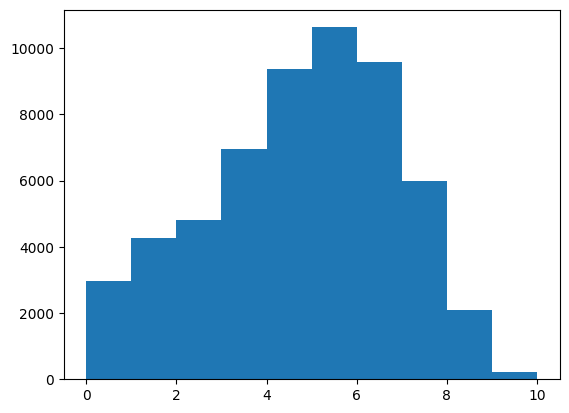

In [5]:
# turn float to int between 1 and 10
df['y'] = df['y'].apply(lambda x: int(x*10))

print(df.head())

plt.hist(df['y'])
plt.show()

In [6]:
print(df['y'].value_counts())

y
5     10634
6      9582
4      9378
3      6966
7      5983
2      4807
1      4269
0      2967
8      2080
9       221
10        1
Name: count, dtype: int64


In [7]:
import datasets

#turn df into a dataset
raw_dataset = datasets.Dataset.from_pandas(df)

In [8]:
#raw_datasets = raw_dataset.train_test_split(test_size=0.2)

print(raw_dataset)

Dataset({
    features: ['seq', 'y'],
    num_rows: 56888
})


In [9]:
tokenizer = transformers.AutoTokenizer.from_pretrained(
        modelpath,
        
        model_max_length=100,
        padding_side="right",
        use_fast=True,
        trust_remote_code=True,
    )

In [10]:
from transformers import DataCollatorWithPadding

def tokenize_function(example):
    return tokenizer(example["seq"], truncation=True)

tokenized_dataset = raw_dataset.map(tokenize_function, batched=True)
tokenized_dataset.set_format("torch")

#print(output)
print(tokenized_dataset)

Map: 100%|██████████| 56888/56888 [00:01<00:00, 41111.02 examples/s]

Dataset({
    features: ['seq', 'y', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 56888
})


In [11]:
# pos_shapes = []

# for i in range(len(tokenized_dataset['input_ids'])):
#     if(pos_shapes.__contains__(tokenized_dataset['input_ids'][i].shape)):
#         continue
#     else:
#         print(tokenized_dataset['input_ids'][i].shape)
#         pos_shapes.append(tokenized_dataset['input_ids'][i].shape)

# print(pos_shapes)

In [12]:
#split into train and validation set
tokenized_datasets = tokenized_dataset.train_test_split(test_size=0.2)

In [13]:
# pos_shapes = []

# for i in range(len(output['input_ids'])):
#     if(pos_shapes.__contains__(output['input_ids'][i].shape)):
#         continue
#     else:
#         pos_shapes.append(output['input_ids'][i].shape)

# print(pos_shapes)

In [14]:
print(tokenized_datasets)

tokenized_datasets = tokenized_datasets.remove_columns(["seq"])
tokenized_datasets = tokenized_datasets.rename_column("y", "labels")
tokenized_datasets.set_format("torch")
tokenized_datasets["train"].column_names


DatasetDict({
    train: Dataset({
        features: ['seq', 'y', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 45510
    })
    test: Dataset({
        features: ['seq', 'y', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 11378
    })
})


['labels', 'input_ids', 'token_type_ids', 'attention_mask']

In [15]:
from torch.utils.data import DataLoader

batch_size = 128

print(tokenizer.pad_token_id)
print(tokenizer.model_max_length)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt", padding="longest", max_length=tokenizer.model_max_length)

train_dataloader = DataLoader(
    tokenized_datasets["train"], shuffle=True, batch_size=batch_size, collate_fn=data_collator
)
eval_dataloader = DataLoader(
    tokenized_datasets["test"], batch_size=batch_size, collate_fn=data_collator
)


3
100


In [16]:
# proof data collator is working

# pos_shapes = []

# for batch in train_dataloader:
#     for i in range(len(batch['input_ids'])):
#         if(pos_shapes.__contains__(batch['input_ids'][i].shape)):
#             continue
#         else:
#             pos_shapes.append(batch['input_ids'][i].shape)
    
#     if(len(pos_shapes)> 1):
#         print("WTF")
#     pos_shapes = []

# print(pos_shapes)

# for batch in train_dataloader:
#     print(batch['labels'])
#     print(batch['input_ids'])
#     print(batch['token_type_ids'])
#     print(batch['attention_mask'])
#     break

# for batch in train_dataloader:
#     print(batch['input_ids'])
#     break

# for batch in train_dataloader_n:
#     print(batch['input_ids'])
#     break

In [17]:
# pos_shapes = []

# for batch in train_dataloader:
#     if(pos_shapes.__contains__(batch['input_ids'].shape)):
#         continue
#     else:
#         pos_shapes.append(batch['input_ids'].shape)

# print(pos_shapes)

In [18]:
model = transformers.AutoModelForSequenceClassification.from_pretrained(
    modelpath,
    cache_dir=None,
    num_labels=10,
    trust_remote_code=True,
)

model.cuda()

C:\Users\robin/.cache\huggingface\modules\transformers_modules\zhihan1996\DNABERT-2-117M\1d020b803b871a976f5f3d5565f0eac8f2c7bb81\bert_layers.py:125: UserWarning: Unable to import Triton; defaulting MosaicBERT attention implementation to pytorch (this will reduce throughput when using this model).
  warnings.warn(
Some weights of the model checkpoint at zhihan1996/DNABERT-2-117M were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassi

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(4096, 768, padding_idx=0)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertUnpadAttention(
            (self): BertUnpadSelfAttention(
              (dropout): Dropout(p=0.0, inplace=False)
              (Wqkv): Linear(in_features=768, out_features=2304, bias=True)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
          )
          (mlp): BertGatedLinearUnitMLP(
            (gated_layers): Linear(in_feat

In [19]:
for batch in train_dataloader:
    break
print({k: v.shape for k, v in batch.items()})

# batch['labels'] = batch['labels'].to('cuda:0')
# batch['input_ids'] = batch['input_ids'].to('cuda:0')
# batch['token_type_ids'] = batch['token_type_ids'].to('cuda:0')
# batch['attention_mask'] = batch['attention_mask'].to('cuda:0')

# print(model.device)

# outputs = model(**batch)
# print(outputs.loss, outputs.logits.shape)

You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'labels': torch.Size([128]), 'input_ids': torch.Size([128, 9]), 'token_type_ids': torch.Size([128, 9]), 'attention_mask': torch.Size([128, 9])}


In [20]:
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr=3e-5)



c:\Users\robin\anaconda3\envs\dnabert\lib\site-packages\transformers\optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [21]:
from transformers import get_scheduler

num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=50,
    num_training_steps=num_training_steps,
)
print(num_training_steps)

1068


In [22]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)
device

device(type='cuda')

In [23]:
from tqdm.auto import tqdm
import evaluate

metric = evaluate.load("accuracy")

progress_bar = tqdm(range(num_training_steps))

accuracylist = []
losslist = []

model.train()

for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        # model.eval()
        # logits = outputs.logits
        # predictions = torch.argmax(logits, dim=-1)
        # metric.add_batch(predictions=predictions, references=batch["labels"])
        
        # calculate accuracy
        predictions = torch.argmax(outputs.logits, dim=-1)

        accuracy = (batch["labels"] == predictions).sum() / len(batch["labels"])
        accuracylist.append(accuracy)
        losslist.append(loss.item())

        progress_bar.set_description(f"Training loss: {loss.item()} | accuracy :{accuracy}")
        progress_bar.update(1)

#save model 
model.save_pretrained("./models/test3")

Training loss: 2.1021151542663574 | accuracy :0.1640625:  62%|██████▏   | 657/1068 [59:59<1:17:28, 11.31s/it]          

KeyboardInterrupt: 

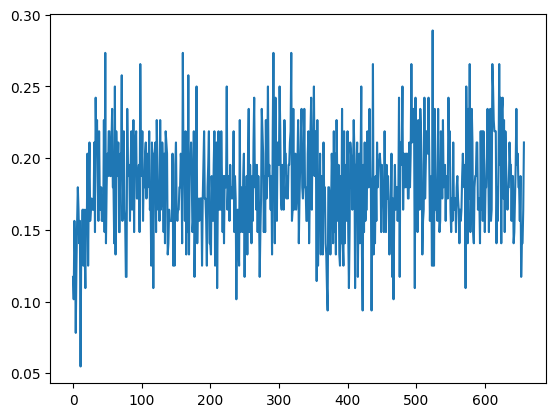

In [24]:
#plot accuracy as line graph
accuracylist = torch.Tensor.cpu(torch.Tensor(accuracylist))

plt.plot(accuracylist)
plt.show()

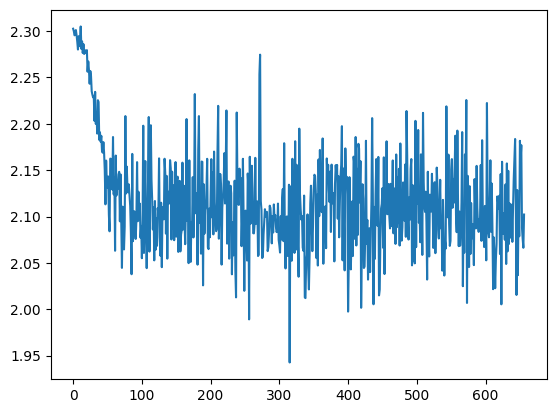

In [25]:
losslist = torch.Tensor.cpu(torch.Tensor(losslist))

plt.plot(losslist)
plt.show()

In [ ]:
from tqdm.auto import tqdm
import evaluate

metric = evaluate.load("accuracy")

progress_bar = tqdm(range(len(eval_dataloader)))

model = transformers.AutoModelForSequenceClassification.from_pretrained(
    "./models/test2",
    cache_dir=None,
    num_labels=10,
    trust_remote_code=True,
)

model.cuda()

metric = evaluate.load("accuracy")
#model.eval()

for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}

    with torch.no_grad():
        outputs = model(**batch)

    #print(outputs.logits)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    # print(predictions)
    # print(batch["labels"])
    # break
    metric.add_batch(predictions=predictions, references=batch["labels"])
    progress_bar.update(1)

metric.compute()

100%|██████████| 89/89 [05:15<00:00,  3.55s/it]

{'accuracy': 0.10775180172262261}